# **Food Deserts and Fast Food Hot Spots**

In [1]:
# Import Neccessary Libraries 
import pandas as pd
import numpy as np
import geopandas as gpd 
import os
from census import Census
from us import states
from sklearn.impute import KNNImputer
from scipy.stats import gaussian_kde
from shapely import distance
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points
import matplotlib.pyplot as plt

### 1) Load, Preprocess, and Clean data

In [2]:
# set working env 
# Stella's env: 
#os.chdir('/Users/stellameserve/Documents/GW/senior_yr/Semester_8/GEOG_3198/Final_Project')
# Maryana's env: 
os.chdir('/Users/maryanashnitser/Desktop')

# Load in neccessary Data
# all data is in a folder within the working env called "data"
philly_aoi = gpd.read_file('programming_final_proj/philly_aoi')
fast_food = gpd.read_file('programming_final_proj/fast_food.geojson')
grocery = gpd.read_file('programming_final_proj/grocery_stores.geojson')
transit = gpd.read_file('programming_final_proj/Transit_Stops.geojson')
census_blocks = gpd.read_file('programming_final_proj/Census_Block_Groups_2020')
parks = gpd.read_file('programming_final_proj/PPR_Properties.geojson')
water_bodies = gpd.read_file('programming_final_proj/Hydrographic_Features_Poly')

# set the CRS to EPSG:32618 which is UTM 18 
philly_aoi = philly_aoi.to_crs('EPSG:32618')
fast_food = fast_food.to_crs('EPSG:32618')
ff_locations = fast_food
grocery = grocery.to_crs('EPSG:32618')          
transit = transit.to_crs('EPSG:32618')   
census_blocks = census_blocks.to_crs('EPSG:32618')      
parks = parks.to_crs('EPSG:32618')   
water_bodies = water_bodies.to_crs('EPSG:32618')           

In [3]:
len(fast_food)

531

#### A) Handle the Census Data

In [4]:
# activate session 
session = Census('f343a55292f63d05fc254dca9cf906764e18b565')

# Pennsylvania (42) and Philadelphia County (101)
state_fips = '42'
county_fips = '101'

# variables we want 
variables = {
    'poverty_total': 'B17001_001E',
    'poverty_below': 'B17001_002E',
    'no_vehicle': 'B08201_002E',
    'total_households': 'B08201_001E',
    'median_income': 'B19013_001E',
    '35_income_rent': 'B25070_007E',
    'median_age': 'B01002_001E'
}

In [5]:
# Request ACS data for all tracts in Philadelphia
results = session.acs5.state_county_tract(
    list(variables.values()),
    state_fips = state_fips,
    county_fips = county_fips,
    tract = "*"
)

In [6]:
# Convert to df
census_ind = pd.DataFrame(results)

# Rename columns
census_ind = census_ind.rename(columns={
    'B17001_001E': 'poverty_total',
    'B17001_002E': 'poverty_below',
    'B08201_002E': 'no_vehicle',
    'B08201_001E': 'total_households',
    'B19013_001E': 'median_income',
    'B25070_007E': '35_income_rent',
    'B01002_001E': 'median_age',
    'state': 'state_fips',
    'county': 'county_fips',
    'tract': 'tract_fips'
})

In [7]:
# calc missing variables
census_ind['pct_below_poverty'] = census_ind['poverty_below'].astype(float) / census_ind['poverty_total'].astype(float)
census_ind['pct_no_vehicle'] = census_ind['no_vehicle'].astype(float) / census_ind['total_households'].astype(float)

In [8]:
# create a GEOID column in the census df 
census_ind['GEOID'] = census_ind['state_fips'] + census_ind['county_fips'] + census_ind['tract_fips']

# GEOID in the census shp has BLKGRPCE in the GEOID which we don't need 
# remove the last BLKGRPCE number from GEOID 
census_blocks['GEOID'] = census_blocks['GEOID'].str[:-1]


In [9]:
# join the tabular data to the geodataframe  
census = census_blocks.merge(census_ind, on='GEOID', how='left')

In [10]:
# there are some null values 
# census uses -666666666.0 as null so im going to set that to null so we can handle it 
census.replace(-666666666.0, np.nan, inplace=True)

# Check for NaNs
print("NaN counts before imputation:")
print(census.isna().sum())


NaN counts before imputation:
OBJECTID              0
STATEFP               0
COUNTYFP              0
TRACTCE               0
BLKGRPCE              0
GEOID                 0
NAMELSAD              0
MTFCC                 0
FUNCSTAT              0
ALAND                 0
AWATER                0
INTPTLAT              0
INTPTLON              0
Shape__Are            0
Shape__Len            0
geometry              0
poverty_total         0
poverty_below         0
no_vehicle            0
total_households      0
median_income        55
35_income_rent        0
median_age           38
state_fips            0
county_fips           0
tract_fips            0
pct_below_poverty    44
pct_no_vehicle       48
dtype: int64


In [11]:
# imputate the missing data with KNN

# Select numeric columns
columns_to_impute = census.select_dtypes(include=[np.number]).columns.tolist()

# Fit KNN on df (including complete rows)
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(census[columns_to_impute])

# Convert back to DataFrame
imputed_df = pd.DataFrame(imputed, columns=columns_to_impute, index=census.index)

# Only fill in NaNs - non missing original values are untouched 
for col in columns_to_impute:
    census[col] = census[col].combine_first(imputed_df[col])

# Check for NaNs after imputation
print("NaN counts after imputation:")
print(census.isna().sum())

NaN counts after imputation:
OBJECTID             0
STATEFP              0
COUNTYFP             0
TRACTCE              0
BLKGRPCE             0
GEOID                0
NAMELSAD             0
MTFCC                0
FUNCSTAT             0
ALAND                0
AWATER               0
INTPTLAT             0
INTPTLON             0
Shape__Are           0
Shape__Len           0
geometry             0
poverty_total        0
poverty_below        0
no_vehicle           0
total_households     0
median_income        0
35_income_rent       0
median_age           0
state_fips           0
county_fips          0
tract_fips           0
pct_below_poverty    0
pct_no_vehicle       0
dtype: int64


/var/folders/zs/qg91ct2s3r1dh50y68w3rrf80000gn/T/ipykernel_17238/3509528115.py:15: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  census[col] = census[col].combine_first(imputed_df[col])


#### B) Clean the Waterbodies and Parks

<Axes: >

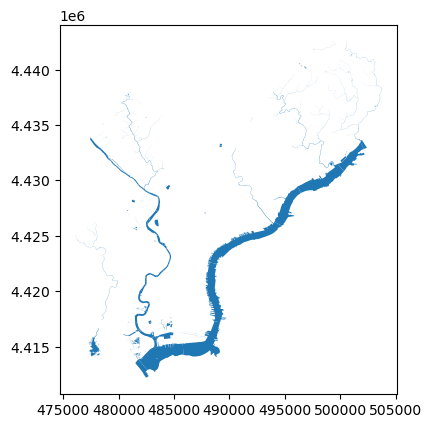

In [12]:
# only select rivers in the philadelphia city municipality 
phil_water_bodies = water_bodies[water_bodies['muni'] == 'Philadelphia city']
phil_water_bodies.plot()

<Axes: >

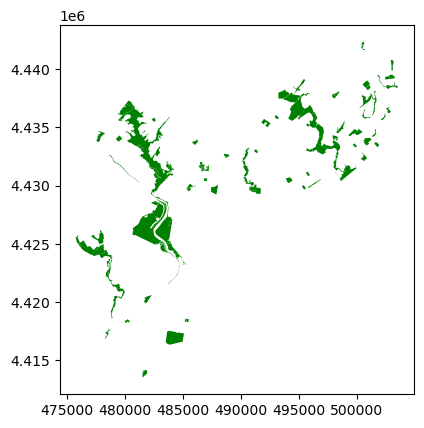

In [13]:
# Clean the Parks by removing parks that are small

parks = parks[parks['Shape__Area'] > 100000] # so not confident as to what this number is. Maybe meters squared? acres? just did it until the small ones were gone 

#explore 
parks.plot(color='green')

### 3) Remove Parks and Water bodies from Philadelphia SHP

In [14]:
# Create a single geometry of all parks and water
parks_union = parks.unary_union
water_union = water_bodies.unary_union

/var/folders/zs/qg91ct2s3r1dh50y68w3rrf80000gn/T/ipykernel_17238/1360192898.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  parks_union = parks.unary_union
/var/folders/zs/qg91ct2s3r1dh50y68w3rrf80000gn/T/ipykernel_17238/1360192898.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  water_union = water_bodies.unary_union


In [15]:
# Subtract parks from each census geometry 
census_without_parks = census.copy()
census_without_parks['geometry'] = census_without_parks.geometry.difference(parks_union)

# remove water bodies
census_without_parks['geometry'] = census_without_parks.geometry.difference(water_union)
census_clean= census_without_parks.copy()

In [16]:
# Census without the parks or waterbodies 
census_clean.explore()

#### C) Clean up the Grocery Stores to contain standard grocery stores 

In [17]:
# liSt of philly grocery stores
store_names = ['ShopRite',
               'Acme',
               'Walmart',
               'Sprouts',
               'ALDI',
               'Save-A-Lot',
               'Giant',
               'Wegmans',
               "Trader Joe's",
               'Lidl',
               'Whole Foods',
               'MOMS'
]

# Keep only rows where name is in store names & only keep the name and geometry column
grocery_stores = grocery[grocery['name'].str.contains('|'.join(store_names), case=False, na=False)][['name', 'geometry']]

#### D) Clean up Fast Food to contain only chain fast food places

In [18]:
# Want to remove local fast food resturants from the df 
# liSt of philly grocery stores

'''
ff_names = ["McDonald's",
               'Chick-fil-A',
               "Wendy's",
               'Burger King',
               'Taco Bell',
               'KFC',
               'Popeyes',
               "Papa John's",
               'Shake Shack'
               "Domino's",
]
'''
# Keep only rows where name is in store names & only keep the name and geometry column
#ff_locations = fast_food[fast_food['name'].str.contains('|'.join(ff_names), case=False, na=False)][['name', 'geometry']]

'\nff_names = ["McDonald\'s",\n               \'Chick-fil-A\',\n               "Wendy\'s",\n               \'Burger King\',\n               \'Taco Bell\',\n               \'KFC\',\n               \'Popeyes\',\n               "Papa John\'s",\n               \'Shake Shack\'\n               "Domino\'s",\n]\n'

In [19]:

ff_locations.head()
len(ff_locations)

531

In [20]:
#convert polygons to point
ff_locations = ff_locations.to_crs("EPSG:4326")
ff_locations = ff_locations.to_crs('EPSG:32618')
# ff_locations.centroid
ff_locations["x"] = gpd.GeoSeries(ff_locations.centroid).x
ff_locations["y"] = gpd.GeoSeries(ff_locations.centroid).y
ff_locations.head()

id            @id access     addr:city addr:country addr:door  \
0   way/49916279   way/49916279   None  Philadelphia         None      None   
1   way/52495486   way/52495486   None  Philadelphia         None      None   
2  way/189706826  way/189706826   None  Philadelphia         None      None   
3  way/200234832  way/200234832   None          None         None      None   
4  way/202984673  way/202984673   None  Philadelphia         None      None   

  addr:full addr:housename addr:housenumber addr:postcode  ... toilets  \
0      None           None             1575         19131  ...    None   
1      None           None             8500         19128  ...    None   
2      None  Dunkin Donuts             2522         19125  ...    None   
3      None           None             None          None  ...    None   
4      None           None              104         19104  ...    None   

  toilets:access toilets:wheelchair  \
0           None               None   
1           None               None   
2           None               None   
3           None               None   
4           None               None   

                                             website website:menu wheelchair  \
0  https://www.mcdonalds.com/us/en-us/location/31...         None       None   
1  https://www.mcdonalds.com/us/en-us/location/38...         None       None   
2  https://locations.dunkindonuts.com/en/pa/phila...         None       None   
3                                               None         None       None   
4  https://locations.papajohns.com/united-states/...         None       None   

  wheelchair:description                                           geometry  \
0                   None  POLYGON ((480844.562 4425567.829, 480844.399 4...   
1                   None  POLYGON ((479620.975 4434867.13, 479630.594 44...   
2                   None  POLYGON ((489789.554 4425352.396, 489782.627 4...   
3                   None  POLYGON ((481979.76 4421531.817, 481987.671 44...   
4                   None  POLYGON ((482705.687 4422797.152, 482706.467 4...   

               x             y  
0  480845.784751  4.425559e+06  
1  479634.842678  4.434871e+06  
2  489797.224208  4.425339e+06  
3  481978.525865  4.421541e+06  
4  482691.993848  4.422803e+06  

[5 rows x 101 columns]

## 2) Food Desert Analysis 

In [21]:
'''
Find Proximity to grocery stores 
- Create a function to calculate proximity 
    - Compute distance from census tract to nearest grocery store 
'''

# proximity calculator for any obj and then a census tract 
def proximity_calculator(obj, tracts, obj_name=''): 
    
    # make all the objects into one 
    obj_union = obj.geometry.unary_union # --> use .unary_union shapely bc expects one geometry later on
    # empty list to store proximity 
    proximity_list = []

    for index, tract in tracts.geometry.items(): # iterate through tracts in the geoseries while getting the index 
        nearest_obj = nearest_points(tract, obj_union)[1] # find the nearest store to that tract 
        distance = tract.distance(nearest_obj) # calculate the distance in meters to the closest grocery store or transit line 
        proximity_list.append(distance) # append distance to grocery store
    
    # Assign distances back to GeoDataFrame
    tracts[obj_name +'_proximity'] = proximity_list
    
    return tracts
          
proximity_calculator(grocery_stores, census_clean, obj_name="store")

/var/folders/zs/qg91ct2s3r1dh50y68w3rrf80000gn/T/ipykernel_17238/3141256102.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  obj_union = obj.geometry.unary_union # --> use .unary_union shapely bc expects one geometry later on


OBJECTID STATEFP COUNTYFP TRACTCE BLKGRPCE        GEOID       NAMELSAD  \
0            1      42      101  019000        1  42101019000  Block Group 1   
1            2      42      101  019100        3  42101019100  Block Group 3   
2            3      42      101  019700        3  42101019700  Block Group 3   
3            4      42      101  019900        1  42101019900  Block Group 1   
4            5      42      101  020000        1  42101020000  Block Group 1   
...        ...     ...      ...     ...      ...          ...            ...   
1333      1334      42      101  030502        1  42101030502  Block Group 1   
1334      1335      42      101  030600        1  42101030600  Block Group 1   
1335      1336      42      101  002000        1  42101002000  Block Group 1   
1336      1337      42      101  002100        1  42101002100  Block Group 1   
1337      1338      42      101  002000        2  42101002000  Block Group 2   

      MTFCC FUNCSTAT   ALAND  ...  total_households median_income  \
0     G5030        S   99233  ...            2356.0       45814.0   
1     G5030        S  153496  ...            2750.0       65048.0   
2     G5030        S   58267  ...            2214.0       27979.0   
3     G5030        S  108795  ...            1823.0       25810.0   
4     G5030        S  124485  ...             474.0       17531.0   
...     ...      ...     ...  ...               ...           ...   
1333  G5030        S  198394  ...            1835.0       62270.0   
1334  G5030        S  185589  ...            2930.0       58231.0   
1335  G5030        S  162005  ...            1182.0      103611.0   
1336  G5030        S   90240  ...             995.0      102969.0   
1337  G5030        S  128078  ...            1182.0      103611.0   

     35_income_rent  median_age  state_fips county_fips  tract_fips  \
0              23.0        32.0          42         101      019000   
1               0.0        32.0          42         101      019100   
2               0.0        35.7          42         101      019700   
3               0.0        31.8          42         101      019900   
4               0.0        28.1          42         101      020000   
...             ...         ...         ...         ...         ...   
1333            0.0        24.8          42         101      030502   
1334           42.0        43.6          42         101      030600   
1335           36.0        34.9          42         101      002000   
1336           32.0        34.0          42         101      002100   
1337           36.0        34.9          42         101      002000   

      pct_below_poverty  pct_no_vehicle  store_proximity  
0              0.320869        0.217317        41.556959  
1              0.251623        0.129818       506.507120  
2              0.562259        0.482385       968.065301  
3              0.481611        0.501371       631.007934  
4              0.450761        0.784810      1087.623824  
...                 ...             ...              ...  
1333           0.168845        0.110627       850.639129  
1334           0.114817        0.176792       694.922065  
1335           0.079208        0.399323       575.193777  
1336           0.088024        0.303518       596.266139  
1337           0.079208        0.399323       645.950894  

[1338 rows x 29 columns]

In [22]:
'''
Find proximity to public transit 
- Use function to calculate proximity
    - Compute distance from census tract to nearest transit line 
'''
# Modify the DataFrame in place
proximity_calculator(transit, census_clean, obj_name="transit")

/var/folders/zs/qg91ct2s3r1dh50y68w3rrf80000gn/T/ipykernel_17238/3141256102.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  obj_union = obj.geometry.unary_union # --> use .unary_union shapely bc expects one geometry later on


OBJECTID STATEFP COUNTYFP TRACTCE BLKGRPCE        GEOID       NAMELSAD  \
0            1      42      101  019000        1  42101019000  Block Group 1   
1            2      42      101  019100        3  42101019100  Block Group 3   
2            3      42      101  019700        3  42101019700  Block Group 3   
3            4      42      101  019900        1  42101019900  Block Group 1   
4            5      42      101  020000        1  42101020000  Block Group 1   
...        ...     ...      ...     ...      ...          ...            ...   
1333      1334      42      101  030502        1  42101030502  Block Group 1   
1334      1335      42      101  030600        1  42101030600  Block Group 1   
1335      1336      42      101  002000        1  42101002000  Block Group 1   
1336      1337      42      101  002100        1  42101002100  Block Group 1   
1337      1338      42      101  002000        2  42101002000  Block Group 2   

      MTFCC FUNCSTAT   ALAND  ...  median_income 35_income_rent median_age  \
0     G5030        S   99233  ...        45814.0           23.0       32.0   
1     G5030        S  153496  ...        65048.0            0.0       32.0   
2     G5030        S   58267  ...        27979.0            0.0       35.7   
3     G5030        S  108795  ...        25810.0            0.0       31.8   
4     G5030        S  124485  ...        17531.0            0.0       28.1   
...     ...      ...     ...  ...            ...            ...        ...   
1333  G5030        S  198394  ...        62270.0            0.0       24.8   
1334  G5030        S  185589  ...        58231.0           42.0       43.6   
1335  G5030        S  162005  ...       103611.0           36.0       34.9   
1336  G5030        S   90240  ...       102969.0           32.0       34.0   
1337  G5030        S  128078  ...       103611.0           36.0       34.9   

      state_fips  county_fips tract_fips  pct_below_poverty  pct_no_vehicle  \
0             42          101     019000           0.320869        0.217317   
1             42          101     019100           0.251623        0.129818   
2             42          101     019700           0.562259        0.482385   
3             42          101     019900           0.481611        0.501371   
4             42          101     020000           0.450761        0.784810   
...          ...          ...        ...                ...             ...   
1333          42          101     030502           0.168845        0.110627   
1334          42          101     030600           0.114817        0.176792   
1335          42          101     002000           0.079208        0.399323   
1336          42          101     002100           0.088024        0.303518   
1337          42          101     002000           0.079208        0.399323   

      store_proximity  transit_proximity  
0           41.556959           0.000000  
1          506.507120           0.000000  
2          968.065301         137.123464  
3          631.007934           0.000000  
4         1087.623824           0.000000  
...               ...                ...  
1333       850.639129           0.000000  
1334       694.922065           0.000000  
1335       575.193777           0.000000  
1336       596.266139           0.000000  
1337       645.950894           0.000000  

[1338 rows x 30 columns]

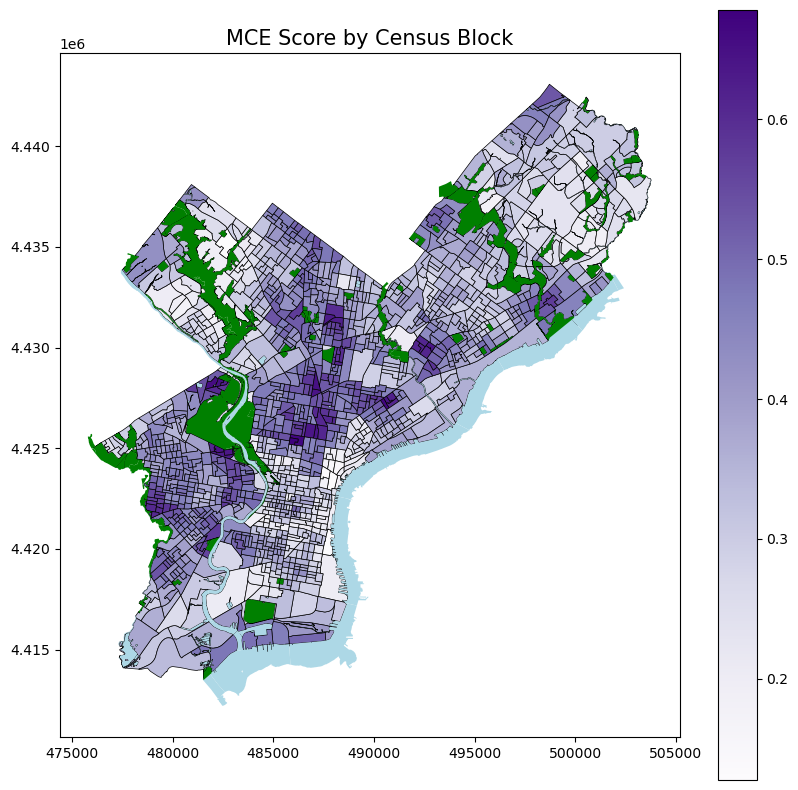

In [23]:
'''
Conduct MCE 
- Create an MCE function 
    - Define the weighting scheme
        - Grocery store proximity 
        - Income level
        - Age
        - Public transit proximity 
        - Vehicle ownership 
    - Combine weighted features into composite index 
    - Classify census tracts based on threshold values 

'''
#normalize data using min max scaling 
def normalize (series):
    return (series - series.min()) / (series.max() - series.min())

def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

columns_to_normalize = [
    "store_proximity", 
    "pct_no_vehicle", 
    "pct_below_poverty", 
    "median_income", 
    "median_age"
]
# create normalized columns applying norm function, add 'norm_' prefix
census_clean[[f"norm_{col}" for col in columns_to_normalize]] = census_clean[columns_to_normalize].apply(normalize)

#inverse income so low income corresponds to higher food desert mce score 
census_clean["inv_income"] = 1 - census_clean["norm_median_income"]

#define weights for each variable 
weights = {
    "norm_median_age": .1,
    "norm_store_proximity": 0.3,
    "norm_pct_no_vehicle": 0.2,
    "norm_pct_below_poverty": 0.2,
    "inv_income": 0.2 
}

#apply weights 
census_clean["mce_score"] = (
    census_clean["norm_store_proximity"] * weights["norm_store_proximity"] +
    census_clean["norm_pct_no_vehicle"] * weights["norm_pct_no_vehicle"] +
    census_clean["norm_pct_below_poverty"] * weights["norm_pct_below_poverty"] +
    census_clean["inv_income"] * weights["inv_income"] +
    census_clean["norm_median_age"] * weights["norm_median_age"]
)

#Create map of mce scores per census tract 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title('MCE Score by Census Block', fontsize=15)
census_clean.plot(column='mce_score',  cmap='Purples', linewidth=0.5, edgecolor='black',legend=True, ax=ax
)
#add waterbodies and parks 
phil_water_bodies.plot(ax=ax, color='lightblue')
parks.plot(ax=ax, color='green')
#display map
plt.show()


In [24]:
#make sure fastfood locations in correct CRS
ff_locations = ff_locations.to_crs('EPSG:32618')

In [25]:

import geopandas as gpd
from sklearn.cluster import DBSCAN

# Convert DataFrame to GeoDataFrame with geometry from lon/lat
gdf = gpd.GeoDataFrame(ff_locations, geometry=gpd.points_from_xy(ff_locations['x'], ff_locations['y']), crs='EPSG:4326')  # WGS84

# Project to meters (example: UTM zone 18N or Web Mercator)
gdf = gdf.to_crs('EPSG:3857')  # Web Mercator; units in meters

# Extract coordinates in meters
coords = np.array([(point.x, point.y) for point in gdf.geometry])

# Run DBSCAN with eps = 500 meters
db = DBSCAN(eps=500, min_samples=10).fit(coords)
gdf['cluster'] = db.labels_

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [33]:
print(ff_locations[['x', 'y']].head())

               x             y
0  480845.784751  4.425559e+06
1  479634.842678  4.434871e+06
2  489797.224208  4.425339e+06
3  481978.525865  4.421541e+06
4  482691.993848  4.422803e+06


In [47]:
# Assume x/y are already in meters
coords = ff_locations[['x', 'y']].values

# Run DBSCAN with real-world meters
db = DBSCAN(eps=600, min_samples=5).fit(coords)
ff_locations['cluster'] = db.labels_

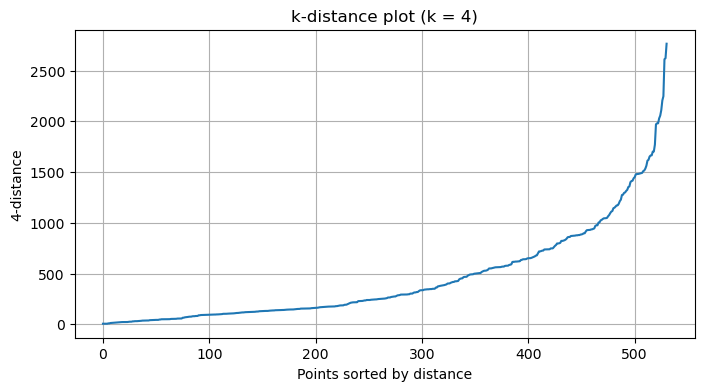

In [48]:

from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
# Set k = min_samples - 1 (because the point itself counts as the first neighbor)
k = 4# If your DBSCAN uses min_samples=10
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(coords)
distances, indices = neighbors_fit.kneighbors(coords)
# Sort the distance to the k-th nearest neighbor for each point
k_distances = np.sort(distances[:, k-1])

# Plot
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.ylabel(f"{k}-distance")
plt.xlabel("Points sorted by distance")
plt.title(f"k-distance plot (k = {k})")
plt.grid(True)
plt.show()

/var/folders/zs/qg91ct2s3r1dh50y68w3rrf80000gn/T/ipykernel_17238/3800604363.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


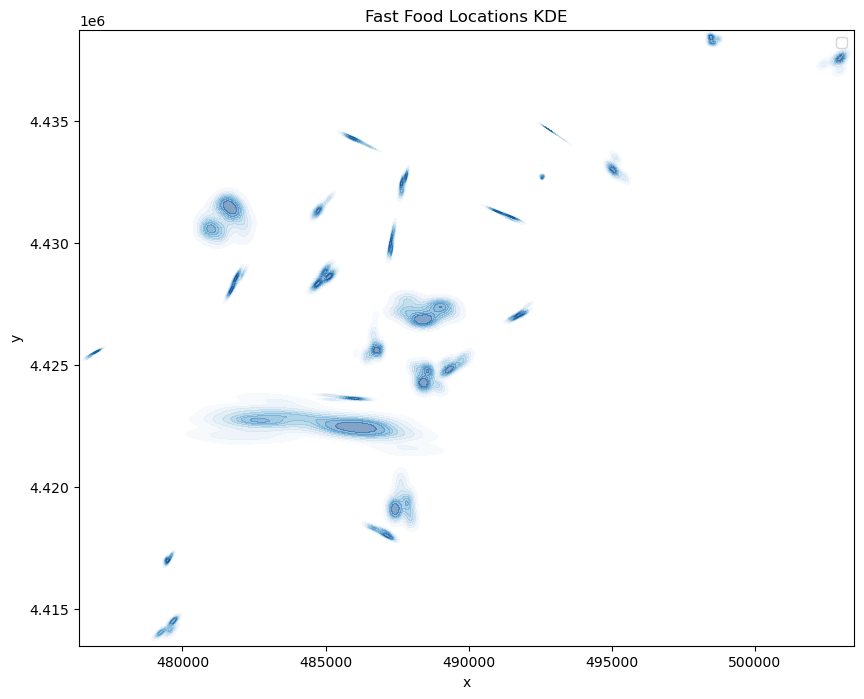

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
# Plot  clusters
census_clean.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=ax)
for cluster_id in sorted(ff_locations['cluster'].unique()):
    if cluster_id == -1:
        continue 
    cluster_data = ff_locations[ff_locations['cluster'] == cluster_id]
    sns.kdeplot(
        x=cluster_data['x'],
        y=cluster_data['y'],
        fill=True,
        cmap="Blues",
        alpha=0.5,
        label=f"Cluster {cluster_id}"
    )
plt.legend()
plt.title("Fast Food Locations KDE")
plt.show()

/var/folders/zs/qg91ct2s3r1dh50y68w3rrf80000gn/T/ipykernel_17238/807935876.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


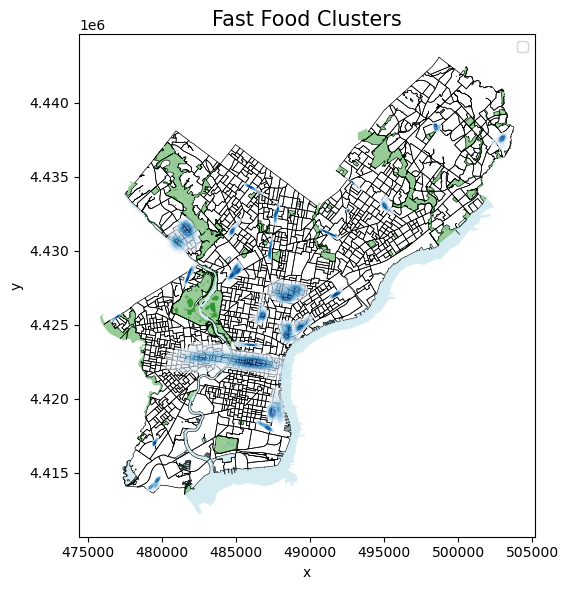

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title('Fast Food Clusters', fontsize=15)

census_clean.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=ax)

for cluster_id in sorted(ff_locations['cluster'].unique()):
    if cluster_id == -1:
        continue 
    cluster_data = ff_locations[ff_locations['cluster'] == cluster_id]
    sns.kdeplot(
        x=cluster_data['x'],
        y=cluster_data['y'],
        fill=True,
        cmap="Blues",
        alpha=0.6,
        ax=ax,       
        label=f"Cluster {cluster_id}"
    )

phil_water_bodies.plot(ax=ax, color='lightblue', alpha=0.5, edgecolor='none')
parks.plot(ax=ax, color='green', alpha=0.4, edgecolor='none')

plt.legend()
plt.tight_layout()
plt.show()


/var/folders/zs/qg91ct2s3r1dh50y68w3rrf80000gn/T/ipykernel_17238/848165505.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


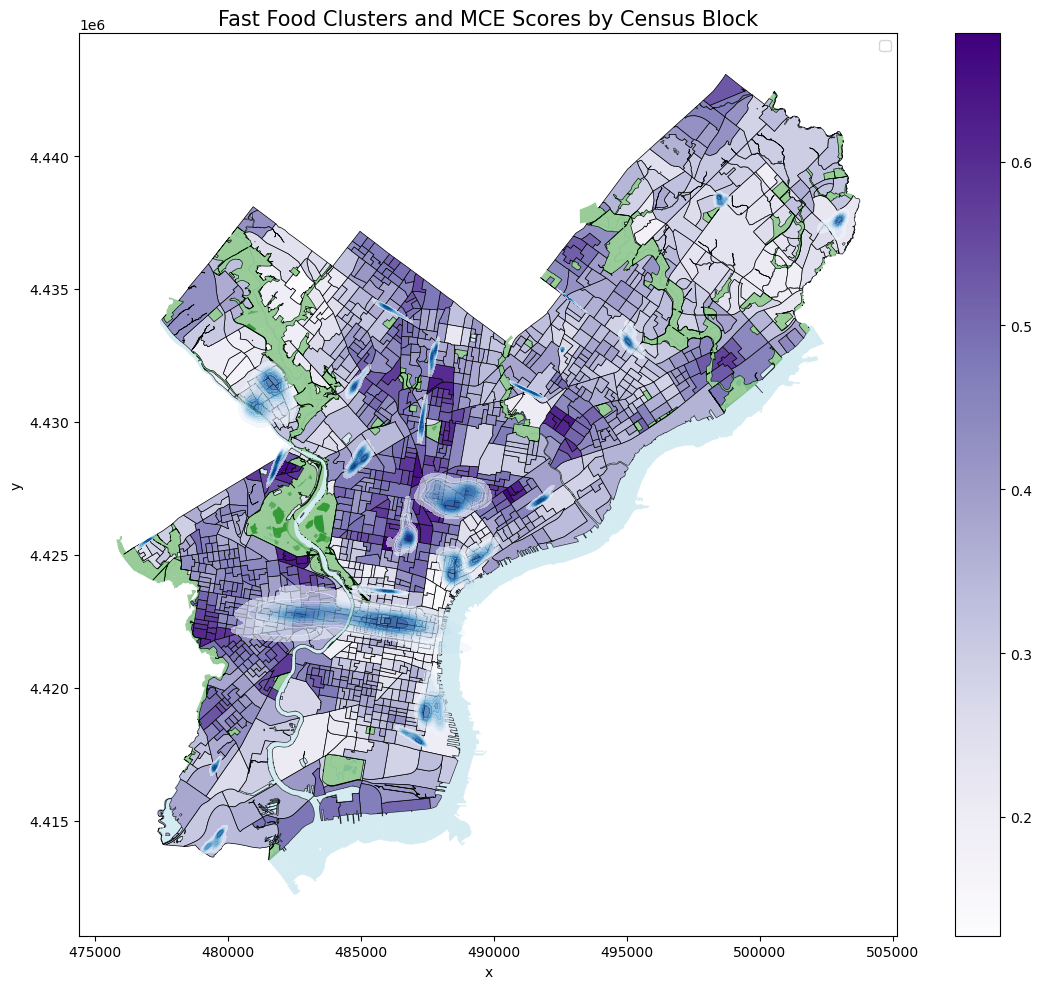

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

#map of mce by census block overlayed with KDE 

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.set_title('Fast Food Clusters and MCE Scores by Census Block', fontsize=15)

census_clean.plot(column='mce_score', cmap ='Purples', linewidth=0.5, edgecolor='black', legend=True, ax=ax)

for cluster_id in sorted(ff_locations['cluster'].unique()):
    if cluster_id == -1:
        continue 
    cluster_data = ff_locations[ff_locations['cluster'] == cluster_id]
    sns.kdeplot(
        x=cluster_data['x'],
        y=cluster_data['y'],
        fill=True,
        cmap="Blues",
        alpha=0.6,
        ax=ax,       
        label=f"Cluster {cluster_id}"
    )

phil_water_bodies.plot(ax=ax, color='lightblue', alpha=0.5, edgecolor='none')
parks.plot(ax=ax, color='green', alpha=0.4, edgecolor='none')

plt.legend()
plt.tight_layout()
plt.show()


In [52]:
from scipy.stats import gaussian_kde
import rasterio
from rasterio.transform import from_origin



# Filter out noise points
valid_points = ff_locations[ff_locations['cluster'] != -1]
x = valid_points['x'].values
y = valid_points['y'].values
xy = np.vstack([x, y])

# Create KDE
kde = gaussian_kde(xy)

# Define grid
xmin, ymin, xmax, ymax = valid_points[['x', 'y']].agg(['min', 'max']).values.flatten()
n_pixels = 500 
x_res = (xmax - xmin) / n_pixels
y_res = (ymax - ymin) / n_pixels

xgrid, ygrid = np.mgrid[xmin:xmax:n_pixels*1j, ymin:ymax:n_pixels*1j]
positions = np.vstack([xgrid.ravel(), ygrid.ravel()])
kde_values = np.reshape(kde(positions).T, xgrid.shape)

# Save to GeoTIFF
transform = from_origin(xmin, ymax, x_res, y_res)

with rasterio.open(
    "kde_output.tif",
    "w",
    driver="GTiff",
    height=kde_values.shape[0],
    width=kde_values.shape[1],
    count=1,
    dtype="float32",
    crs="EPSG:4326",  
    transform=transform,
) as dst:
    dst.write(np.flipud(kde_values).astype("float32"), 1) 


In [53]:
census_blocks['centroid'] = census_blocks.geometry.centroid

with rasterio.open("kde_output.tif") as src:
    census_blocks['kde_val'] = [
        list(src.sample([(pt.x, pt.y)]))[0][0]
        for pt in census_blocks['centroid']
    ]


In [54]:
#extract kde values 
from rasterstats import zonal_stats

stats = zonal_stats(census_blocks, "kde_output.tif", stats=["mean"])
census_blocks["kde_mean"] = [s["mean"] for s in stats]


In [55]:
census_blocks.head()

OBJECTID STATEFP COUNTYFP TRACTCE BLKGRPCE        GEOID       NAMELSAD  \
0         1      42      101  019000        1  42101019000  Block Group 1   
1         2      42      101  019100        3  42101019100  Block Group 3   
2         3      42      101  019700        3  42101019700  Block Group 3   
3         4      42      101  019900        1  42101019900  Block Group 1   
4         5      42      101  020000        1  42101020000  Block Group 1   

   MTFCC FUNCSTAT   ALAND  AWATER     INTPTLAT      INTPTLON     Shape__Are  \
0  G5030        S   99233       0  +40.0075552  -075.1011888  169335.851562   
1  G5030        S  153496       0  +40.0122247  -075.1070147  261972.085938   
2  G5030        S   58267       0  +40.0184461  -075.1377887   99461.687500   
3  G5030        S  108795       0  +40.0060857  -075.1390074  185647.449219   
4  G5030        S  124485       0  +39.9999436  -075.1511448  212383.296875   

    Shape__Len                                           geometry  \
0  1933.959793  POLYGON ((491196.135 4428451.572, 491222.874 4...   
1  2711.845151  POLYGON ((490457.599 4429280.452, 490641.901 4...   
2  1350.802348  POLYGON ((488156.602 4429840.418, 488184.167 4...   
3  1730.437613  POLYGON ((487965.784 4428381.077, 487979.572 4...   
4  2015.502177  POLYGON ((486877.799 4427546.006, 486880.99 44...   

                         centroid       kde_val      kde_mean  
0  POINT (491363.357 4428601.569)  2.363282e-09  2.374120e-09  
1  POINT (490866.739 4429120.419)  1.599439e-09  1.568829e-09  
2  POINT (488241.409 4429814.548)  6.714543e-11  6.518875e-11  
3  POINT (488135.271 4428442.821)  5.495046e-10  5.391943e-10  
4  POINT (487098.166 4427762.794)  5.266050e-10  5.467306e-10

In [56]:
census_clean.head()

OBJECTID STATEFP COUNTYFP TRACTCE BLKGRPCE        GEOID       NAMELSAD  \
0         1      42      101  019000        1  42101019000  Block Group 1   
1         2      42      101  019100        3  42101019100  Block Group 3   
2         3      42      101  019700        3  42101019700  Block Group 3   
3         4      42      101  019900        1  42101019900  Block Group 1   
4         5      42      101  020000        1  42101020000  Block Group 1   

   MTFCC FUNCSTAT   ALAND  ...  pct_no_vehicle store_proximity  \
0  G5030        S   99233  ...        0.217317       41.556959   
1  G5030        S  153496  ...        0.129818      506.507120   
2  G5030        S   58267  ...        0.482385      968.065301   
3  G5030        S  108795  ...        0.501371      631.007934   
4  G5030        S  124485  ...        0.784810     1087.623824   

  transit_proximity  norm_store_proximity  norm_pct_no_vehicle  \
0          0.000000              0.014569             0.255140   
1          0.000000              0.177568             0.152412   
2        137.123464              0.339377             0.566340   
3          0.000000              0.221214             0.588631   
4          0.000000              0.381291             0.921399   

  norm_pct_below_poverty  norm_median_income  norm_median_age  inv_income  \
0               0.410404            0.185636         0.384164    0.814364   
1               0.321835            0.301446         0.384164    0.698554   
2               0.719151            0.078250         0.438416    0.921750   
3               0.615998            0.065190         0.381232    0.934810   
4               0.576541            0.015342         0.326979    0.984658   

   mce_score  
0   0.338769  
1   0.326247  
2   0.587103  
3   0.532375  
4   0.643605  

[5 rows x 37 columns]

In [57]:
#merge census blocks and census clean to add mean kde value column
regression_gdb = census_blocks.merge(census_clean, on='GEOID', how='left')

In [58]:
!pip install statsmodels
import statsmodels.api as sm

# Drop missing values (just in case)
df = regression_gdb[['mce_score', 'kde_mean']].dropna()

# Regression variables 
X = df['kde_mean']
y = df['mce_score']
#constant
X = sm.add_constant(X)
# OLS regression
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              mce_score   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     597.1
Date:                Mon, 05 May 2025   Prob (F-statistic):          7.26e-125
Time:                        17:58:30   Log-Likelihood:                 4722.7
No. Observations:                5158   AIC:                            -9441.
Df Residuals:                    5156   BIC:                            -9428.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4197      0.002    250.811      0.0

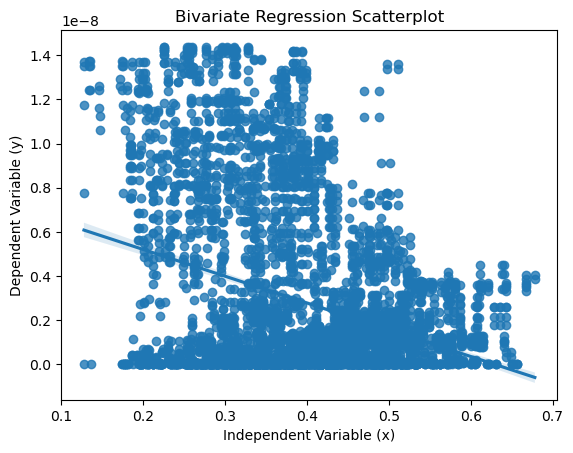

In [59]:
# plot regression
df = regression_gdb[['kde_mean', 'mce_score']].dropna()

x = df['mce_score']
y = df['kde_mean']

sns.regplot(x= x, y=y, data=df)

plt.xlabel('Independent Variable (x)')
plt.ylabel('Dependent Variable (y)')
plt.title('Bivariate Regression Scatterplot')

# Show the plot
plt.show()

In [60]:
'''
a one unit increase in kde_mean (fast food density) is associated with a 0.4182 increase on 
MCE score, all else constant. 
This means that higher fast food density is associated with grater food desert 
vulnerability
'''

'\na one unit increase in kde_mean (fast food density) is associated with a 0.4182 increase on \nMCE score, all else constant. \nThis means that higher fast food density is associated with grater food desert \nvulnerability\n'